In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import MixupDS, load_img
from incendio.layers import ConvBlock, ResBlock, mish, Mish

In [65]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [66]:
dir_u = Path('data/imagewang-160/unsup/')

In [79]:
ds = MixupDS(dir_u)
dl = DataLoader(ds, batch_size=2, shuffle=False)

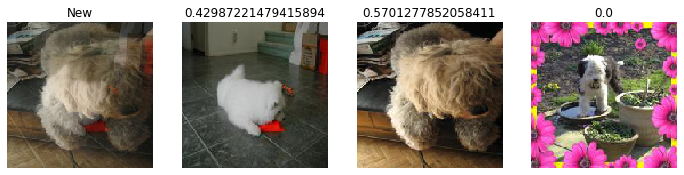

In [80]:
*imgs, w = ds[100]
show_images(imgs, figsize=(12, 4), titles=['New']+w.tolist())
plt.show()

In [106]:
*xb, yb = next(iter(dl))

In [107]:
xb[0].shape

torch.Size([2, 3, 128, 128])

In [109]:
len(xb)

4

In [123]:
conv = nn.Conv2d(3, 5, 3)
fc = nn.AdaptiveAvgPool2d(1)
tmp = conv(xb[0])
tmp.shape

torch.Size([2, 5, 126, 126])

In [125]:
fc(tmp).squeeze().shape

torch.Size([2, 5])

torch.Size([8, 3, 128, 128])


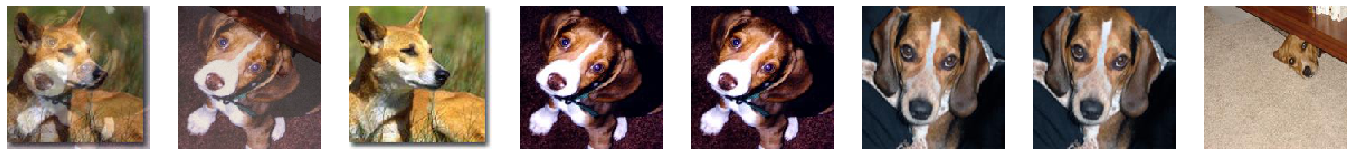

In [112]:
stk = torch.cat(xb, dim=0)
print(stk.shape)
show_images(stk)

In [113]:
tmp = conv(stk)
tmp.shape

torch.Size([8, 5, 126, 126])

In [114]:
bs = 2
shape = tmp.shape
tmp.view(bs, shape[1]*shape[0]//bs, *shape[-2:]).shape

torch.Size([2, 20, 126, 126])

In [295]:
class UnmixerModel(nn.Module):
    
    def __init__(self, n=3, c_in=3, f_dims=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel=3, act=Mish()):
        super().__init__()
        if len(f_dims) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel, activation=act, stride=stride) 
              for f_in, f_out, stride in zip((c_in, *f_dims), f_dims, strides)]
        )
        self.pool = AdaptiveConcatPool2d(1)

    def forward(self, *xb):
        bs = xb[0].shape[0]
        # Stack along batch dimension so all images can be processed at once.
        xb = torch.cat(xb, dim=0)                    # (bs*(n+1), c, h, w)
        xb = self.conv(xb)                           # (bs*(n+1), f[-1], h, w)
        xb = self.pool(xb).squeeze()                 # (bs*(n+1), emb_dim))
        xb = xb.view(bs, -1, xb.shape[-1])           # (bs, n+1, emb_dim)
        x_new, x_src = xb[:, 0, :], xb[:, 1:, :]
        return (x_new.unsqueeze(1) * x_src).sum(-1)  # (bs, n)

In [296]:
net = UnmixerModel()
net

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [297]:
# # (bs, n+1, enc_dim)
# xn, xs = net(*xb)
# xn.shape, xs.shape

res = net(*xb)
res.shape

torch.Size([2, 3])

In [298]:
res

tensor([[1964.0205, 1911.6881, 2971.2969],
        [3478.9438, 3478.9438, 2110.0117]], grad_fn=<SumBackward1>)

In [287]:
F.softmax(res, dim=-1)

tensor([[0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000]], grad_fn=<SoftmaxBackward>)

In [299]:
F.log_softmax(res, dim=-1)

tensor([[-1.0073e+03, -1.0596e+03,  0.0000e+00],
        [-6.9315e-01, -6.9315e-01, -1.3696e+03]], grad_fn=<LogSoftmaxBackward>)